<table style="border: none" align="center">
   <tr style="border: none">
      <th style="border: none"><font face="verdana" size="4" color="black"><b>  EXP:1 Decision Tree  </b></font></font></th>
   </tr> 
</table>

In this notebook we demonstrate Model training and adversarial training using ART on the IRIS dataset.

Sensitivity to training set details:
https://nbviewer.jupyter.org/github/Azure/azureml-examples/blob/main/notebooks/train-lightgbm-local.ipynb


## Contents

1.	[Load prereqs and data](#prereqs)
2.  [Data scale, Train and evaluate a baseline classifier](#classifier)
3.  [Adversarially train a robust classifier](#adv_training)
4.	[Evaluate the robust classifier](#evaluation)

<a id="prereqs"></a>
## 1. Load prereqs and data

In [1]:
# Initialization:
%reload_ext autoreload
%autoreload 2

In [2]:
# Downloading the Libraries and Dependencies:
import os
import numpy as np
import pandas as pd
from IPython.display import Image
from typing import Tuple
from matplotlib.colors import ListedColormap
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
%reload_ext watermark
%watermark  -d -u -a "Habtamu desalegn" -v -p numpy,pandas,scipy,matplotlib,sklearn,mlxtend

Habtamu desalegn 
last updated: 2020-11-23 

CPython 3.8.3
IPython 7.19.0

numpy 1.19.4
pandas 1.1.3
scipy 1.5.3
matplotlib 3.3.3
sklearn 0.23.2
mlxtend 0.17.3


#### Loading the IRIS dataset

In [4]:
COLUMNS = ["sepal_length","sepal_width","petal_length","petal_width","species"]
PATH = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
df = pd.read_csv(PATH, header=None, index_col=None, names = COLUMNS)
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [5]:
from sklearn.preprocessing import LabelEncoder

X = df.drop('species', axis=1).values
y = df['species']

enc = LabelEncoder()
y = enc.fit_transform(y)

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42,shuffle=True)

In [7]:
print(f'X_train.shape: {X_train.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_test.shape: {y_test.shape}')

X_train.shape: (105, 4)
y_train.shape: (105,)
X_test.shape: (45, 4)
y_test.shape: (45,)


<a id="classifier"></a>
## 2. Preprocess ,Train and Evaluate a classifier

1. [Data Scaling](#2_1)
2. [Train a model: LightGBM](#2_2)
3. [Evaluate the model](#2_3)

<a id="2_1"></a>
### 1. Data Scaling

Bringing features onto the same scale

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

def preprocess_minmax(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Normalization -- Min-max scaling

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param X_train: Data instances.
    :param X_test: Data instances.
    :return: Rescaled values of `X_train`, `X_test`.
    """
    
    # normalize
    #print('normalized:', (ex - ex.min()) / (ex.max() - ex.min()))
    
    mms = MinMaxScaler()
    X_train_norm = mms.fit_transform(X_train)
    X_test_norm = mms.transform(X_test)
    
    return X_train_norm, X_test_norm

def preprocess_standard(X_train: np.ndarray, X_test: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Standard scaling: Gaussian with zero mean and unit variance

    Scales `X_train` to [0, 1] , `X_test` to [0, 1]

    :param x: Data instances.
    :param y: Labels.
    :return: Rescaled values of `x`, `y`.
    """
    
    stdsc = StandardScaler()
    X_train_std = stdsc.fit_transform(X_train)
    X_test_std = stdsc.transform(X_test)
    
    return X_train_std, X_test_std

In [16]:
# Preprocess - Training and testing set
### standard
#(X_train, X_test) = preprocess_standard(X_train[:,[0,1]], X_test[:,[0,1]])    #  0=sepal length, 1=sepal width
(X_train, X_test) = preprocess_standard(X_train[:,2:], X_test[:,2:])           #  2=petal length, 3=petal width

### normalize
#(X_train, X_test) = preprocess_minmax(X_train[:,[0,1]], X_test[:,[0,1]])     #  0=sepal length, 1=sepal width
#(X_train, X_test) = preprocess_minmax(X_train[:,2:], X_test[:,2:])           #  2=petal length, 3=petal width

### with out normalization
#(X_train, X_test) = X_train[:,[0,1]], X_test[:,[0,1]]      #  0=sepal length, 1=sepal width
#(X_train, X_test) = X_train[:,2:], X_test[:,2:]            #  2=petal length, 3=petal width


<a id="2_2_1"></a>
### 2.1 Training a DecisionTree via scikit-learn

In [17]:
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=4, 
                              random_state=42)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=42)

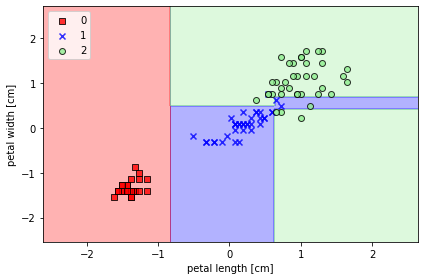

In [18]:
plot_decision_regions(X_train, y_train, model)
plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-8-bb5eb72466a6>:33: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated since 3.2 and will be removed two minor releases later. Use an explicit list instead.
  plt.scatter(X_test[:, 0],


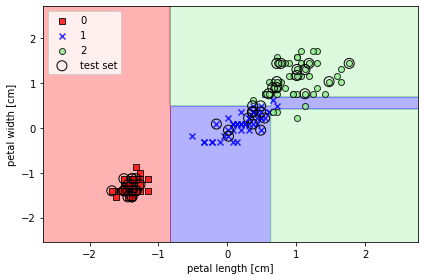

In [19]:
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=model,
                      test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_20.png', dpi=300)
plt.show()

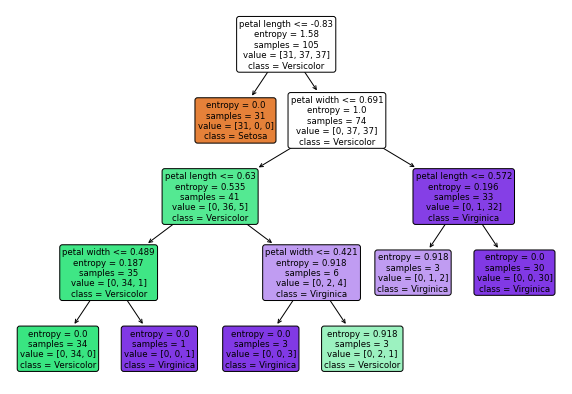

In [20]:
from sklearn.tree import plot_tree


plt.figure(figsize=(10, 7))

plot_tree(model, 
          filled=True, 
          rounded=True,
          class_names=['Setosa', 
                       'Versicolor',
                       'Virginica'],
          feature_names=['petal length', 
                         'petal width']) 

plt.show()

<a id="2_3"></a>
### Evaluate the model

Looking at different performance evaluation metrics

#### Reading a confusion matrix

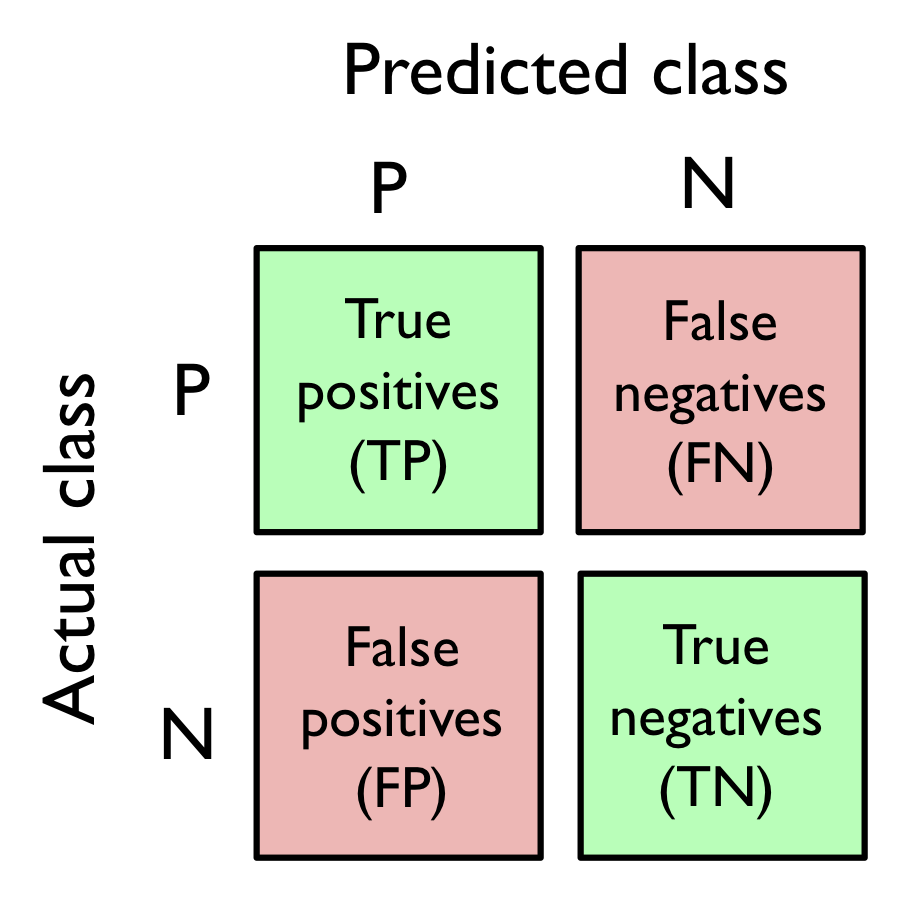

In [21]:
Image(filename='images/confusion_matrix.png', width=300) 

In [25]:
# note: micro-average is preferable if you suspect there might be class imbalance
# ref: https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin

# Evaluate the model
from sklearn import metrics
from sklearn.preprocessing import LabelBinarizer

def multiclass_roc_auc_score(y_test, y_pred, average='macro'):
    lb = LabelBinarizer()
    y_test = lb.fit_transform(y_test)
    y_pred = lb.fit_transform(y_pred)
    
    return metrics.roc_auc_score(y_test, y_pred, average=average)

y_pred = model.predict(X_test)
print(f"prediction: {y_pred}")
print(f"y_true: {y_test}")
print(f'Misclassified examples:{(y_test != y_pred).sum()}')

# Confusion Matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred)
print(f"confusion matrix:\n {conf_mat}")

# AUC
auc = multiclass_roc_auc_score(y_test, y_pred, average='macro')
print(f"auc: {auc}")

# Accuracy
accuracy = metrics.accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Precision
precision = metrics.precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision}")

# Recall
recall = metrics.recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall}")

# F1
f1 = metrics.f1_score(y_test, y_pred, average='macro')
print(f"F1: {f1}")

# classification_report
print(f"classification_report:\n {metrics.classification_report(y_test, y_pred)}")

# Predicting classes and class probabilities
print(f"X_test:\n {X_test[0:5,:]}")
print(f"class probabilities:\n {model.predict_proba(X_test[0:5,:])}")
print(f"Predicting classes: {model.predict(X_test[0:5,:])}")

prediction: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]
y_true: [1 0 2 1 1 0 1 2 1 1 2 0 0 0 0 1 2 1 1 2 0 2 0 2 2 2 2 2 0 0 0 0 1 0 0 2 1
 0 0 0 2 1 1 0 0]
Misclassified examples:0
confusion matrix:
 [[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]
auc: 1.0
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1: 1.0
classification_report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

X_test:
 [[ 0.48403749 -0.05143998]
 [-1.26851205 -1.26670948]
 [ 1.76924049  1.43388941]
 [ 0.36720086  0.35364985]
 [ 0.54245581  0.21861991]]
class probabilities:
 [[0. 1. 0.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]
 [0. 1. 0.]]
Predicting classes: [1

In [118]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        18
           1       0.83      1.00      0.91        10
           2       1.00      0.88      0.94        17

    accuracy                           0.96        45
   macro avg       0.94      0.96      0.95        45
weighted avg       0.96      0.96      0.96        45



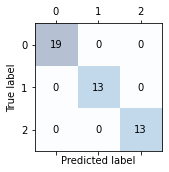

In [26]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(conf_mat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        ax.text(x=j, y=i, s=conf_mat[i, j], va='center', ha='center')

plt.xlabel('Predicted label')
plt.ylabel('True label')

plt.tight_layout()
#plt.savefig('images/06_09.png', dpi=300)
plt.show()

Max f1_score on max_depth   2  is  1.0


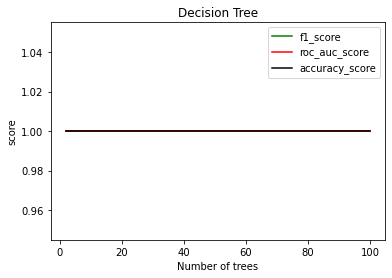

In [29]:
# imports
import time

def train_model(max_depth, X_train, y_train):
    t1 = time.time()
    model = DecisionTreeClassifier(max_depth = max_depth, random_state=42)
    model.fit(X_train, y_train)
    t2 = time.time()

    return model, t2 - t1


def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred, average='macro')
    precision = metrics.precision_score(y_test, y_pred, average='macro')
    auc = multiclass_roc_auc_score(y_test, y_pred, average='macro')
    f1 = metrics.f1_score(y_test, y_pred, average='macro')
    
    return acc, recall, precision, auc, f1


max_c = 0;
max_j = 0;

y_acc = []
y_recall = []
y_precision = []
y_auc = []
y_fsc = []

for j in range(2, 101):
    x_vals = np.arange(2, 101)
    # train model
    clf, train_time = train_model(j , X_train, y_train)
    acc, recall, precision, auc, f1 = evaluate_model(clf, X_test, y_test)
    y_acc.append(acc)
    y_recall.append(recall)
    y_precision.append(precision)
    y_auc.append(auc)
    y_fsc.append(f1)
    
    if f1 > max_c:
        max_c = f1
        max_j = j
        
    
print("Max f1_score on max_depth  ",  max_j, " is ", max_c)
plt.figure()
plt.xlabel('Number of trees')
plt.ylabel('score')
plt.title('Decision Tree')
plt.plot(x_vals, y_fsc, color = "green", label = "f1_score")
plt.plot(x_vals, y_auc, color = "red", label = "roc_auc_score")
plt.plot(x_vals, y_acc, color = "black", label = "accuracy_score")

plt.legend()

#### K-fold cross-validation


https://nbviewer.jupyter.org/github/vmirly/python-machine-learning-book-3rd-edition/blob/master/ch06/ch06.ipynb

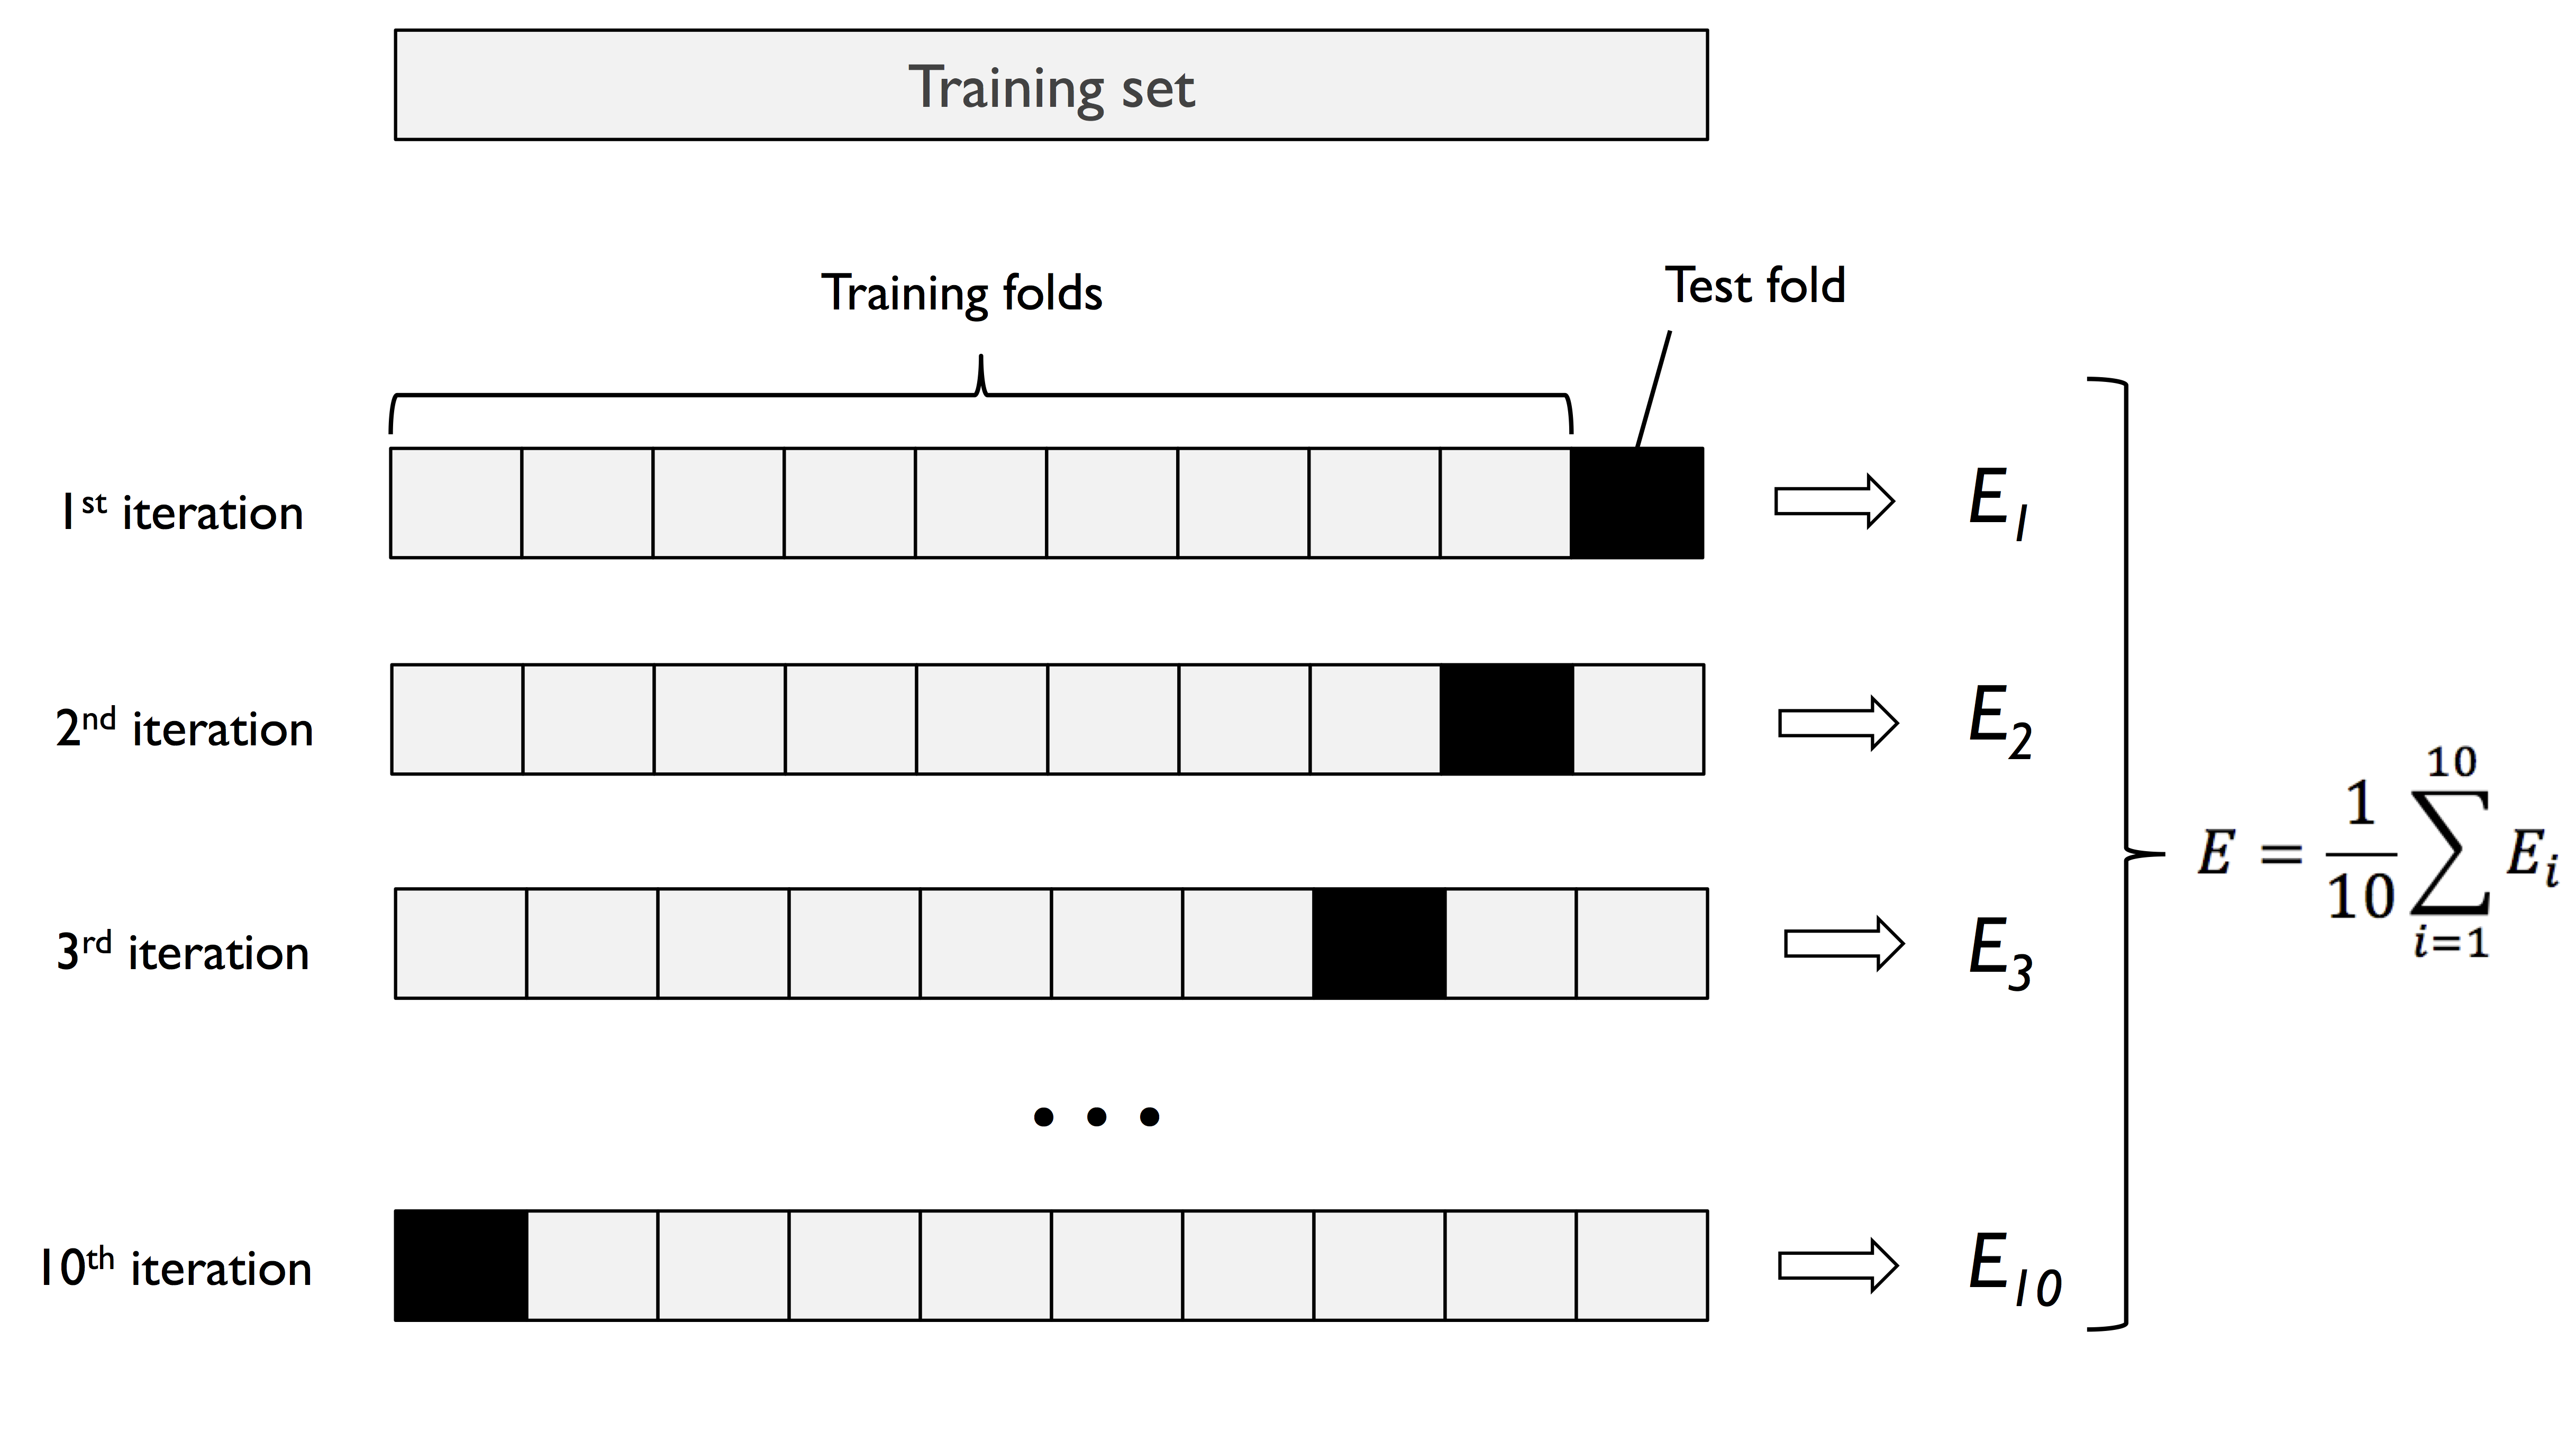

In [30]:
Image(filename='images/kfold.png', width=500)

In [31]:
from sklearn.model_selection import StratifiedKFold    

#CV accuracy: 0.953 +/- 0.043
clf_cv = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=123)

kfold = StratifiedKFold(n_splits=10).split(X, y)
scores = []
for k, (train, test) in enumerate(kfold):
    clf_cv.fit(X[train], y[train])
    score = clf_cv.score(X[test], y[test])
    scores.append(score)
    print('Fold: %2d, Class dist.: %s, Acc: %.3f' % (k+1,
           np.bincount(y[train]), score))
    
print('\nCV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Fold:  1, Class dist.: [45 45 45], Acc: 1.000
Fold:  2, Class dist.: [45 45 45], Acc: 0.933
Fold:  3, Class dist.: [45 45 45], Acc: 1.000
Fold:  4, Class dist.: [45 45 45], Acc: 0.933
Fold:  5, Class dist.: [45 45 45], Acc: 0.933
Fold:  6, Class dist.: [45 45 45], Acc: 0.867
Fold:  7, Class dist.: [45 45 45], Acc: 0.933
Fold:  8, Class dist.: [45 45 45], Acc: 0.933
Fold:  9, Class dist.: [45 45 45], Acc: 1.000
Fold: 10, Class dist.: [45 45 45], Acc: 1.000

CV accuracy: 0.953 +/- 0.043


## 5 Adversarial-Robustness-Toolbox for scikit-learn DecisionTree

In [34]:
from sklearn.tree import DecisionTreeClassifier
from art.estimators.classification import SklearnClassifier
from art.attacks.evasion import ZooAttack

#### 1 Training scikit-learn DecisionTreesClassifier and attacking with ART Zeroth Order Optimization attack

Create and apply Zeroth Order Optimization Attack with ART

Generate adversarial samples:

In [36]:
def get_adversarial_examples(X_train, X_test, y_train):
    
    # Create and fit DecisionTreeClassifier
    model = DecisionTreeClassifier(max_depth=2, random_state=42)
    model.fit(X=X_train, y=y_train)

    # Create ART classifier for scikit-learn DecisionTreeClassifier
    art_classifier = SklearnClassifier(model=model)

    # Create ART Zeroth Order Optimization attack
    zoo = ZooAttack(classifier=art_classifier, confidence=0.0, targeted=False, learning_rate=1e-1, max_iter=20,
                    binary_search_steps=10, initial_const=1e-3, abort_early=True, use_resize=False, 
                    use_importance=False, nb_parallel=1, batch_size=1, variable_h=0.2)

    # Generate adversarial samples with ART Zeroth Order Optimization attack
    X_train_adv = zoo.generate(X_train)
    X_test_adv  = zoo.generate(X_test)
    
    return X_train_adv, X_test_adv, model

### Experiment : 2

Generate adversarial samples:

In [37]:
X_train_adv, X_test_adv, model = get_adversarial_examples(X_train, X_test, y_train)

ZOO: 100%|████████████████████████████████████████████████████████████████████████████████████████████| 45/45 [00:02<00:00, 19.55it/s]


#### Evaluate DecisionTreesClassifier on benign and adversarial samples

evaluate performance on those:

1. Score
2. Predict

##### Score

In [38]:
score = model.score(X_train, y_train)
print("Benign Training Score: %.4f" % score)

Benign Training Score: 0.7619


In [39]:
score = model.score(X_train_adv, y_train)
print("Adversarial Training Score: %.4f" % score)

Adversarial Training Score: 0.3333


#### Predict

In [51]:
print(X_train[0:5, :])
prediction = model.predict(X_train[0:5, :])
print(f"Benign Training Predicted Label: {prediction}")

[[0.6545455  0.10909089]
 [0.7454546  0.21818183]
 [0.59999996 0.0181818 ]
 [0.5272727  0.29090908]
 [0.4        0.14545454]]
Benign Training Predicted Label: [1 2 1 0 0]


In [52]:
print(X_train_adv[0:5, :])
prediction = model.predict(X_train_adv[0:5, :])
prediction
print(f"Adversarial Training Predicted Label: {prediction}")

[[0.6545455  0.10909089]
 [0.71450156 0.21818183]
 [0.5771922  0.11813124]
 [0.6272324  0.29090908]
 [0.39713916 0.04582641]]
Adversarial Training Predicted Label: [1 1 0 1 1]


##### Test score

In [53]:
score = model.score(X_test, y_test)
print("Benign Test Score: %.4f" % score)

Benign Test Score: 0.7778


In [54]:
print(X_test[:5, :])
prediction = model.predict(X_test[:5, :])
print(f"Benign Test Predicted Label: {prediction}")

[[0.7288136  0.08474576]
 [0.81355935 0.16949153]
 [0.7457627  0.1355932 ]
 [0.6101695  0.16949153]
 [0.49152544 0.18644066]]
Benign Test Predicted Label: [2 2 2 1 0]


In [55]:
score = model.score(X_test_adv, y_test)
print("Adversarial Test Score: %.4f" % score)

Adversarial Test Score: 0.2667


In [58]:
print(X_test_adv[0:5, :])
prediction = model.predict(X_test_adv[0:5, :])
print(f"Adversarial Test Predicted Label: {prediction}")

[[0.6969388  0.08474576]
 [0.71685153 0.16949153]
 [0.71558434 0.1355932 ]
 [0.6101695  0.16949153]
 [0.49152544 0.09944782]]
Adversarial Test Predicted Label: [1 1 1 1 1]
